# Simulation Notebook to interact with the PAF Frontend Simulation
The PAF frontend simulation is a comprehensive toolbox. It takes telescope optics, various system noises, signal, and RFI sources into account, allowing a detailed study of various PAF properties. Furthermore, the frontend simulation tool provides an HDF5 file as output. The file stores Auto Covariance Matrices (ACM) of different types (e.g. signal, noise, and RFI). The backend simulation tool (pafsim) benefits from these ACMs because the ACMs can be used to create simulated time series.

This notebook examines how to read the ACMs and generate and process time series. First, we import the pafsim module and create a ProcessingChain object.

Note: A more detailed guide on how to use the pafsim toolbox can be found in `example/example_simulation`. This notebook focuses on the interface to the PAF frontend simulation.

In [1]:
import pafsim.processor as pp

We create an instance of the Generator class by giving the object the name 'generator' and pointing it to the ACM dataset from the frontend simulator. The Generator uses an FrontendSimFile to read from the HDF5 file. Further, we look at the structure of the HDF5 file and some of the PAF properties.

In [2]:
gen = pp.Generator("generator", dataset="frontend_dataset.h5", width=1000000)
print(f"Number of elements: {gen.reader.nelements}")
print(f"Number of polarisations: {gen.reader.npol}")
print("Structure of the HDF5 file:\n" +gen.reader.view())

Number of elements: 21
Number of polarisations: 1
Structure of the HDF5 file:
acms
└─noise
  └─0
    └─allLoss
      └─description: telescope + atmosphere
      └─name: allLoss
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─atmosphere
      └─description: atmospheric noise
      └─name: atmosphere
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─horn
      └─description: antenna noise
      └─name: horn
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─lna
      └─description: lna noise
      └─name: lna
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─sky
      └─description: isotropic thermal noise of environment
      └─name: sky
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─sys
      └─description: t + lna
      └─name: sys
      └─acm (44100)
      └─frequencies (100)
        └─unit: GHz
    └─t
      └─description: sky + allLoss + horn
      └─name: t
      └─acm

## Reconstruction of the input ACMs 
We gather information from the HDF5 structure. For instance, the frontend was simulated at 100 different continuous frequencies. In this section, we reconstruct the input ACMs from our processing chain. To do so, our processing chain consists of the Generator, a channelizer and a Correlator. 

We create the processors and chain them together

In [3]:
xeng = pp.Correlator("xeng", acc=1)
feng = pp.Channelizer("feng", mode="fft", channels=100, window="hamming")
# Chain the different processors
xeng.setPreProcessor(feng)
feng.setPreProcessor(gen)

Start the processing of the different processor objects

In [4]:
gen.process()
feng.process()
xeng.process()

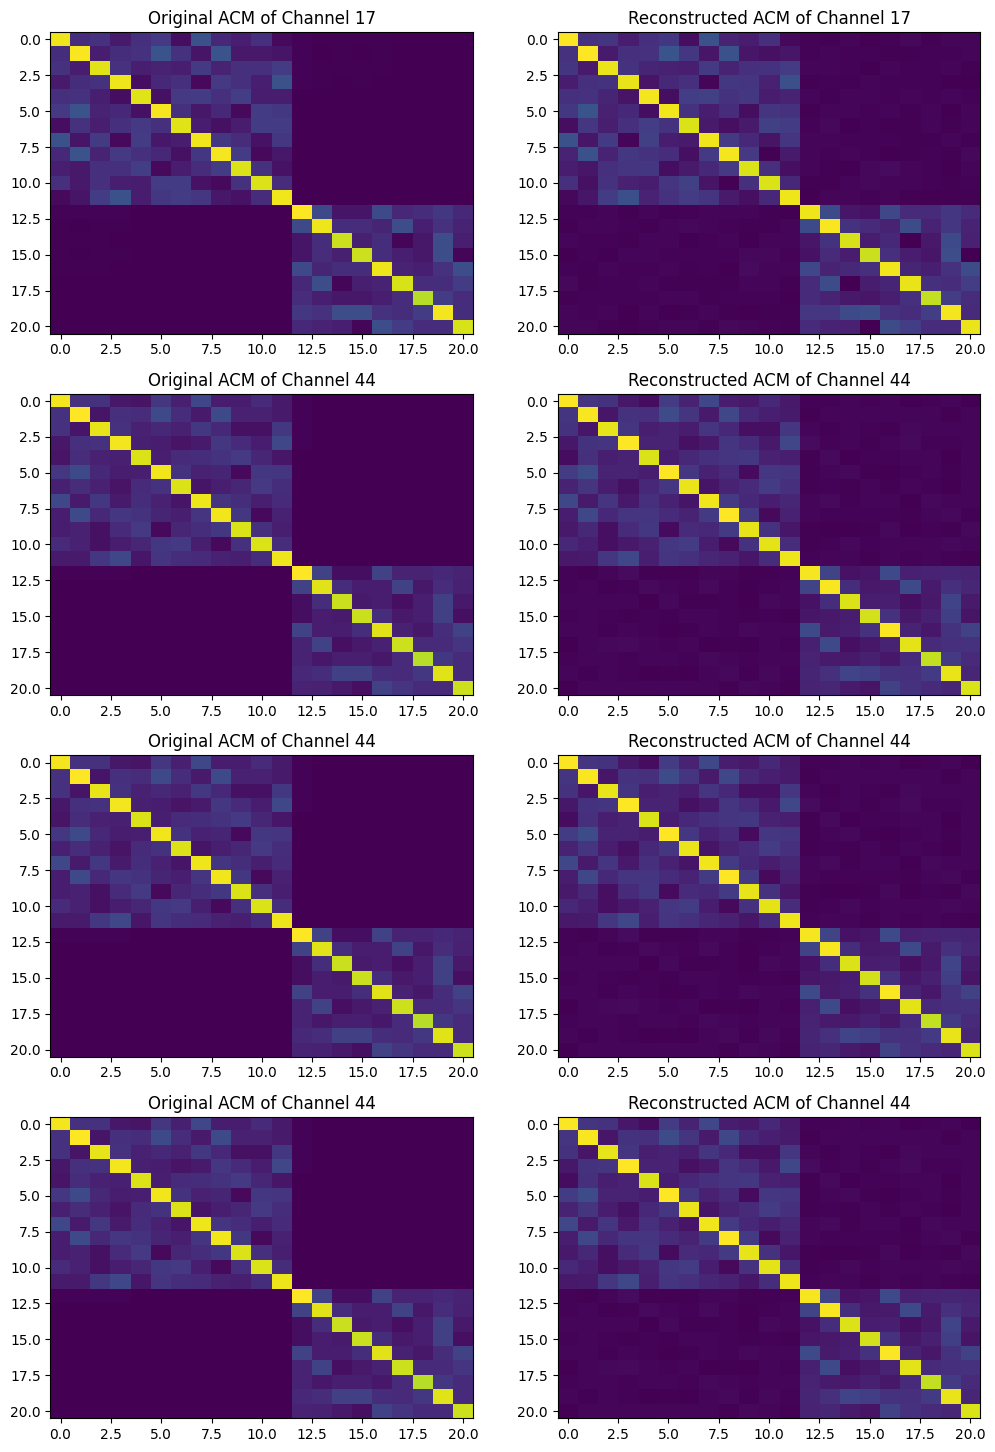

In [5]:
import numpy as np
import matplotlib.pyplot as plt

expect_acms = gen.input
actual_acms = xeng.output

# Plotting some ACMs side-by-side
channels = np.random.randint(0, len(expect_acms), 4) # Channels to plot
fig = plt.figure(num=4*2, figsize=(12,18))
for i, f in enumerate(channels):
    ax = plt.subplot(4, 2, i*2 + 1)
    ax.set_title(f"Original ACM of Channel {f}")
    ax.imshow(np.abs(expect_acms[f]), aspect='auto')
    ax = plt.subplot(4, 2, i*2 + 2)
    ax.set_title(f"Reconstructed ACM of Channel {f}")
    ax.imshow(np.abs(actual_acms[0,f,0]), aspect='auto')

## Beamweight Computation based on MaxSNR

ToDo